In [55]:
import numpy as np
import sympy as sy
from copy import copy
import matplotlib.pyplot as plt
from scipy.linalg import eigh
try:  # SciPy >= 0.19
    from scipy.special import comb, logsumexp
except ImportError:
    from scipy.misc import comb, logsumexp  # noqa 

from functools import partial
import mcint
import random
import math
import scipy.integrate as sci
from scipy import stats
from numba import jit
from functools import partial
import vegas
from numpy import linalg as LA

In [56]:

def append_state(state, index_list, is_fermion = False, ne = 1):
    if is_fermion == True:
        my_sum = 0
        for i in copy(index_list):
            if i>1:
                return
            my_sum = my_sum+i
        if my_sum!=ne:
            return
    state.append(copy(index_list))
    return


def for_recursive(number_of_loops, range_list, state, current_index=0, iter_list = [], is_fermion = False, ne =0):
    if iter_list == []:
        iter_list = [0]*number_of_loops

    if current_index == number_of_loops-1:
        for iter_list[current_index] in range_list[current_index]:
            append_state(state, iter_list, is_fermion, ne)
    else:
        for iter_list[current_index] in range_list[current_index]:
            for_recursive(number_of_loops, iter_list = iter_list, range_list = range_list,  current_index = current_index+1, state= state, is_fermion = is_fermion, ne =ne) 


#### Fock space


class state():
    
    def __init__(self, x,y,pre_factor=1, show=False):
        self.psi_e = x
        self.psi_ph =y
        self.pre_factor = pre_factor
        self.ev = []
        self.ew = []
        self.evT = []
        self.ewT = []
        if show:
            self.show()
        return
    
    def show(self, end=0):
        '''prints current state'''
        
        if self.pre_factor != 1:
            print(sy.S(str(f)), end ="")
        print("|", end ="")
        for e in range(len(self.psi_e)):
            if e == len(self.psi_e)-1:
                print(self.psi_e[e], end ="")
            else:
                print(self.psi_e[e], end =",")
        print(">",end ="")
        print(" |", end ="")
        for ph in range(len(self.psi_ph)):
            if ph == len(self.psi_ph)-1:
                print(self.psi_ph[ph], end ="")
            else:
                print(self.psi_ph[ph], end =",")
        if end==0:
            print(">")
        else:
            print(">", end =" ")
        return
    
    def number_of_phonons(self,j=-1):
        if j==-1:
            return sum(self.psi_ph)
        else:
            return self.psi_ph[j]
    
    def e_index(self,i):
        """returns periodic index i with periode n_e"""
        return i%self.n_e
    
    def C_plus(self,i):
        if self.psi_e[self.e_index(i)]== 0:
            self.psi_e[self.e_index(i)] = 1
        elif self.psi_e[self.e_index(i)]== 1:
            self.psi_e[self.e_index(i)] = 0
            self.pre_factor = self.pre_factor * 0
        return
    
    def C_(self,i):
        if self.psi_e[self.e_index(i)]== 1:
            self.psi_e[self.e_index(i)] = 0
        elif self.psi_e[self.e_index(i)]== 0:
            self.psi_e[self.e_index(i)] = 0
            self.pre_factor = self.pre_factor * 0
        return
    
    def b_plus(self,i):
        if self.psi_ph[i] == self.M:
            self.psi_ph[i] = 0
            self.pre_factor = self.pre_factor * 0
        else: 
            self.psi_ph[i] = self.psi_ph[i] + 1
        return
    
    def b_(self,i):
        if self.psi_ph[i] == 0:
            self.psi_ph[i] = 0
            self.pre_factor = self.pre_factor * 0
        else: 
            self.psi_ph[i] = self.psi_ph[i] - 1
        return
    def Omega_(self,i):
        self.pre_factor = self.psi_e[self.e_index(i)]
        return 
        
        
class H_space():
    def __init__(self, L, M, n_e, show, is_periodic = False):
        self.L=L
        self.M=M
        self.n_e=n_e
        self.states = []
        #self.TH_matrix = np.array([np.array([0.0 for i in range(self.dim_mat)]) for j in range(self.L*(self.M+1)**self.L)])
        self.make_basis(L, M, n_e, show)
        self.dim_mat = comb(L,n_e,exact=True)*(M+1)**L
        self.is_periodic = is_periodic
        if self.dim_mat!= len(self.states):
            print("dim is wrong!")
        self.H_matrix = np.array([np.array([0 for i in range(self.dim_mat)]) for j in range(self.dim_mat)])
        return
                    
    def make_basis(self, L, M, n_e, show):
        ph_states = []
        e_states = []
        for_recursive(range_list = [range(M+1) for _ in range(L)], state = ph_states , number_of_loops=L)
        for_recursive(range_list = [range(n_e+1) for _ in range(L)], state = e_states , number_of_loops=L, is_fermion = True, ne =n_e)
        for x in e_states:
            for y in ph_states:
                self.states.append(state(copy(x),copy(y),1, show=show))

    def e_jump_left(self,i):
        """C⁺C applied to the i-th basis state
        returns if the result is within nummerical basis,
        index of result and normalizazion factor
        """
        if self.n_e == 0 or self.n_e == self.L:
            return False, 0, 0
        elif  (i + (self.M+1)**2) < 2* (self.M+1)**2 and (i + (self.M+1)**2) >=0:
            return True,(i + (self.M+1)**2), 1
        elif self.is_periodic:
            return True,(i + (self.M+1)**2)% (2*(self.M+1)**2), 1
        else:
            return False, 0, 0
    def e_jump_right(self,i):
        """C⁺C applied to the i-th basis state
        returns if the result is within nummerical basis,
        index of result and normalizazion factor
        """
        if self.n_e == 0 or self.n_e == self.L:
            return False, 0, 0
        elif  (i - (self.M+1)**2) < 2* (self.M+1)**2 and (i - (self.M+1)**2) >=0:
            return True,(i - (self.M+1)**2), 1
        elif self.is_periodic:
            return True,(i - (self.M+1)**2)% (2*(self.M+1)**2), 1
        else:
            return False, 0, 0
        
    def b_plus(self,i,j=1):
        """B⁺_j applied to the i-th basis state
        returns if the result is within nummerical basis,
        index of result and normalizazion factor
        """
        if (( i + (self.M+1)**j )//( (self.M+1)**j) ) %(self.M+1)!=0:
            f = i+(self.M+1)**j
            return True, f, np.sqrt(self.states[f].psi_ph[self.L-j-1])
        else:
            return False, 0, 0
    
    def b(self,i,j=1):
        """B_j applied to the i-th basis state
        returns if the result is within nummerical basis,
        index of result and normalizazion factor
        """
        if (( i - (self.M+1)**j )//( (self.M+1)**j) ) %(self.M+1)!=self.M:
            return True,i-(self.M+1)**j , np.sqrt(self.states[i].psi_ph[self.L-j-1])
        else:
            return False, 0, 0
    def Hamiltonian(self,t_0, w_0, gamma):
        """calculate the hamiltonian on the standard basis"""
        self.H_matrix = np.array([np.array([0.0 for i in range(self.dim_mat)]) for j in range(self.dim_mat)])
        for i in range(self.dim_mat):
            a,b,k = self.e_jump_left(i)
            c,d,l = self.e_jump_right(i)
            if a:
                self.H_matrix[i][b] += -t_0*k
            if c:
                self.H_matrix[i][d] += -t_0*l
            self.H_matrix[i][i] += w_0 * self.states[i].number_of_phonons()
            for j in range(self.L):
                if self.states[i].psi_e[self.L-j-1] == 1:
                    e,f, m = self.b_plus(i,j)
                    if e:
                        #print("Ob+ (",self.L-j-1,")", end="")
                        #self.states[i].show()
                        #print("=", end="")
                        #self.states[f].show()
                        #print(m**2)
                        self.H_matrix[i][f] += -gamma * m 
                        #np.sqrt(self.states[f].psi_ph[self.L-j-1])
                    g,h, n = self.b(i,j)
                    if g:
                        #print("Ob (",self.L-j-1,")", end=" ")
                        #self.states[i].show()
                        #print("=", end="")
                        #self.states[h].show()
                        #print(n**2)
                        self.H_matrix[i][h] += -gamma * n
                        #np.sqrt(self.states[i].psi_ph[self.L-j-1])
                    
        #self.H_matrix += w_0*np.eye(self.dim_mat)
        return

    
    def H_diag(self):
        """diagonalizes the Himiltonian and sets ew as Eigenvalues and ev as Eigenvectors"""
        self.ew, self.ev = eigh(self.H_matrix)#np.linalg.eig(self.H_matrix)
        test = []
        for x in range(len(self.ew)):
            if abs(self.ew[x].imag) <1e-15:
                test.append(self.ew[x].real)
            else: 
                test.append(self.ew[x])
        self.ew = test
        return
    def check_symmetric(self, tol=1e-10):
        """checks wheather the Hamiltonian is a symmetric matrix
        with an error tolarence tol"""
        return np.all(np.abs(self.H_matrix-self.H_matrix.T) < tol)
    
    def O_(self, psi, O, order =1 ):
        """maps a state psi into a list of operators O apllied to it. 
        the parameter order specifies the potence of the operators.
        |psi> |--> (O[0]O[1]..O[n])^order |psi>
        """
        if len(O)==1:
            if order == 0:
                print("identity")
                return psi
            elif order == 1:
                res = np.array([0.0 for _ in range(self.dim_mat)]) 
                for i in range(self.dim_mat):
                    j,k,l = O[0](i)
                    if j:
                        res[k] = psi[i] *l
                return res
            elif order>1:
                return self.O_(psi, [O[0]], order -1)
            else:
                print("negative Operation potence")
                return np.array([0.0 for _ in range(self.dim_mat)])
        elif len(O)>1:
            return self.O_(self.O_(psi, [O[-1]], order),  O[:-1], order)
    
    def Expected_value(self, O, beta, is_Mat=False, is_T =False):
        
        if is_T:
            ev = np.array(self.evT)
            ew = self.ewT
        else:
            ev = np.array(self.ev)
            ew = self.ew
        if is_Mat:
            Mat=O
            a = sum([np.exp(-beta* ew[n]) * ev[:,n] @ Mat@ ev[:,n] \
                         /(ev[n] @ ev[n]) \
                         for n in range(len(ew))])
        else:
            a = sum([np.exp(-beta* ew[n]) * ev[:,n] @ \
                         self.O_(ev[:,n]/(ev[:,n] @ev[:,n]),O)\
                         for n in range(len(self.ewT))])
 
        Z = sum([np.exp(-beta* w) for w in ew])    
        return a/Z
    
    def b_plus_b(self,i,j=1):
        ##B⁺B
        aa,bb,cc = self.b(i,j)
        if aa:
            e,f,g = self.b_plus(bb,j)
            return True, f, cc*g
            """if e:
                return True, f, cc*g
            else:
                return False, 0, 0
        """
        else:
                return False, 0, 0
    
    def b_b_plus(self,i,j=1):
        ##BB+
        aa,bb,cc = self.b_plus(i,j)
        if aa:
            e,f,g = self.b(bb,j)
            return True, f, cc*g
            """if e:
                return True, f, cc*g
            else:
                return False, 0, 0
        """
        else:
                return False, 0, 0
    
    def E_moments(self, beta, m, is_T=False):
        """calculates the m-th moment of E for the system with inverse temperature beta"""
        if is_T:
            Z = sum([np.exp(-beta* w) for w in self.ewT])
            a = sum([np.exp(-beta* w) *(w)**m  for w in self.ewT])
        else:
            Z = sum([np.exp(-beta* w) for w in self.ew])
            a = sum([np.exp(-beta* w) *(w)**m  for w in self.ew])
        return a/Z
    
    def C_v(self, beta, is_T=False):
        """calculates the heat capacity for the system with inverse temperature beta"""
        return beta**2 *( self.E_moments(beta,2,is_T = is_T) \
                         -self.E_moments(beta,1,is_T = is_T)**2)
    
    def T(self ,i, order=1):
        """Translation operator returnes index of the translated state i after
        (order)-times translations"""
        if order==0:
            return i
        elif order==1:
            m_1 = self.states[i].number_of_phonons(0)
            m_2 = self.states[i].number_of_phonons(1) 
            delete_phonons = (i)//((self.M+1)**2) *((self.M+1)**2)
            if self.n_e==0 or self.n_e==self.L:
                exchange_electron=0
            else:
                exchange_electron = (delete_phonons - (self.M+1)**2)% (2*(self.M+1)**2)
            add_phonons = exchange_electron+m_1 + m_2*((self.M+1)**1)
            return add_phonons
        else: 
            return self.T(i, order-1)

    
    def checkstate(self,s,k):
        """checks if the state has been 
        already used as a representative and returns
        the states periodicity (-1) for invalid rep."""
        R=-1 ## periodicity
        t = copy(s)
        for i in range(self.L):
            t = self.T(t)
            if t < s:
                ## epresentative of |s〉 is already in the basi
                return R
            elif t == s:
                ##peridoicity is i
                if abs(np.round(k*(i+1),0)-k*(i+1))<1e-10:
                #k % (self.L/(i+1)) !=0:
                    ## state are compatiple with momentum k
                    if (i+1)==1 and k==1:
                        return -1
                    return (i+1)
                #R = i+1
        return R
            
    def find_T_reps(self,k):
        reps = []
        periodicities = []
        for s in range(self.dim_mat):
            R = self.checkstate(s,k)
            if R>=0:
                reps.append(s)
                periodicities.append(R)
        return reps, periodicities
        
    def representative(self, s_):
        r, t, l = s_,s_,0 
        for i in range(self.L): ## should it be (1,self.L-1)?
            t = self.T(t)
            if t < r:
                r=t
                l=i
                return r, l ## representative, number of translations
        return r, l
    
    def T_H_matrix(self,t_0, w_0, gamma, k):
        reps, periodicities = self.find_T_reps(k)
        TH_matrix = np.array([np.array([0.0 for i in range(len(reps))])\
                              for j in range(len(reps))],dtype = 'complex_')
        #print(reps)
        for i in range(len(reps)):
            a=i#reps[i]
            TH_matrix[a][a]+=w_0 * self.states[reps[i]].number_of_phonons()
            
            aa,bb,kk = self.e_jump_left(reps[i])
            cc,dd,ll = self.e_jump_right(reps[i])
            if aa:
                b, R_b = self.representative(bb)
                if b in reps:
                    b = reps.index(b)
                    TH_matrix[a][b] += -t_0*kk *np.sqrt(periodicities[b]/periodicities[a])\
                    *np.exp(1j*2*np.pi*(k+R_b)/self.L)

            if cc:
                b, R_b = self.representative(dd)
                if b in reps:
                    b = reps.index(b)
                    TH_matrix[a][b] += -t_0*ll*np.sqrt(periodicities[b]/periodicities[a])\
                    *np.exp(1j*2*np.pi*(k+R_b)/self.L)
            for j in range(self.L):
                if self.states[reps[i]].psi_e[self.L-j-1] == 1:
                    ee,ff, mm = self.b_plus(reps[i],j)
                    if ee:
                        b, R_b = self.representative(ff)
                        #print("B⁺",j," |",reps[i],"> =", b)
                        if b in reps:
                            b = reps.index(b)
                            TH_matrix[a][b] += -gamma * mm * np.sqrt(periodicities[b]/\
                                                                 periodicities[a])\
                            *np.exp(1j*2*np.pi*(k+R_b)/self.L)
                    gg,hh, nn = self.b(reps[i],j)
                    if gg:
                        b, R_b = self.representative(hh)
                        #print("B",j," |",reps[i],"> =", b)
                        if b in reps:
                            
                            b = reps.index(b)
                            TH_matrix[a][b] += -gamma * nn * np.sqrt(periodicities[b]\
                                                                     /periodicities[a])\
                            *np.exp(1j*2*np.pi*(k+R_b)/self.L)
                        
        #TH_matrix += w_0*np.eye(len(TH_matrix))
        return TH_matrix
        
    def HT_diag(self, t_0, w_0, gamma, show = False):
        """diagonalizes the Himiltonian starting from the momentum basis
        and sets ewT as Eigenvalues and evT as Eigenvectors"""
        H2= self.T_H_matrix(t_0, w_0, gamma, 0)
        H1= self.T_H_matrix(t_0, w_0, gamma, 1)
        
        if show:
            print(np.round(H1,1))
            print(np.round(H2,1))
        w1,v1 = eigh(H1)#np.linalg.eig(self.H_matrix)
        w2,v2 = eigh(H2)
        test = []
        self.ewT, self.evT = [w for w in w1],[v for v in v1]
        for x in range(len(w2)):
            self.ewT.append(w2[x])
            self.evT.append(v2[x])   
        for x in range(len(self.ewT)):
            if abs(self.ewT[x].imag) <1e-15:
                test.append(self.ewT[x].real)
            else: 
                test.append(self.ewT[x])
        self.ewT = test
        data_list = list(sorted(zip(self.ewT,self.evT), key=lambda x: x[0]))
        unzipped_list = [[i for i, j in data_list],\
                 [j for i, j in data_list]]
        self.ewT,self.evT = unzipped_list[0],unzipped_list[1]
        return


In [57]:
## for monte carlo method

def xx(v):
    return np.tan(v)
def dxx(v):
    return 1+np.tan(v)**2
def sub(v,f):
    return f(xx(v))*dxx(v)


In [61]:
class hybrid():
    def __init__(self, method='monte_carlo', n = 15000):
        self.method = method
        self.n = n
        return
    
    def integrate(self, func):
        if self.method =='sci':
            result, error = sci.quad(func,-np.inf,np.inf)
        elif self.method =='sy':
            que =sy.S('q_1')
            expr = func(q)
            result = sy.integrate(expr, (que,-sy.oo,sy.oo))
        elif self.method =='monte_carlo':
            integ = vegas.Integrator([[-np.pi/2, np.pi/2]])
            evalu = integ(partial(sub,f=func), nitn=10, neval=self.n)  # estimate the integral
            result , error = evalu[0].mean, evalu[0].sdev
        elif self.method =='simpson':
            y = func(np.linspace(0,100000,100000))
            result = 2*sci.simpson(y,np.linspace(0,100000,100000 ))
            error =0
        
        return result , error
    
    def ew(self, q, t,w,g,dim=2,Q=0):
        sign = 1
        res_1 = (w*q)**2 /2 + sign*sy.sqrt(g**2*w*q**2 +4*t)
        sign = -1
        res_2 = (w*q)**2 /2 + sign*sy.sqrt(g**2*w*q**2 +4*t)
        if dim==2:
            return np.array([res_1, res_2])
        elif dim==4:
            res_0 = sy.sqrt(w)*g*Q + (w*q)**2 /2
            res_3 = (w*q)**2 /2
            return np.array([res_0,res_1, res_2, res_3])
        
    def ev(self, q, t,w,g,dim=2):
        t_0,gamma,w_0 = t,g,w
        r = q*gamma*np.sqrt(w_0)/(2*t_0)
        sign = 1
        phi_11 = 1/sy.sqrt(1 + (r + sign* sy.sqrt(r**2 + 1))**2)
        phi_22 = -sign/ sy.sqrt(1 + (r - sign* sy.sqrt(r**2 + 1))**2)
        #res_1 = np.array([phi_11,phi_22])
        sign = -1
        phi_1 = 1/sy.sqrt(1 + (r + sign* sy.sqrt(r**2 + 1))**2)
        phi_2 = -sign/ sy.sqrt(1 + (r - sign* sy.sqrt(r**2 + 1))**2)
        #res_2 = np.array([phi_1,phi_2])
        if dim==2:
            res_1 = np.array([phi_11,phi_22])
            res_2 = np.array([phi_1,phi_2])
            return np.array([res_1, res_2])
        elif dim==4:
            res_1 = np.array([0,phi_11,phi_22,0])
            res_2 = np.array([0,phi_1,phi_2,0])
            a1= np.array([1,0,0,0])
            a2= np.array([0,0,0,1])
            return np.array([a1,res_1, res_2,a2])
    
    def Z(self, beta:np.float128,\
      t_0:np.float128,w_0:np.float128\
      ,gamma:np.float128,no_factor = False)->np.float128:
        
        z_factor = (2*np.pi/beta)**(3/2)*np.exp(beta*(w_0+gamma**2/(2*w_0)))/w_0
        que = sy.symbols('q_1')
        w = self.ew(que,t_0,w_0,gamma)
        a = sum([sy.exp(-beta*w[n]) for n in range(2)])
        trH = sy.lambdify(que, a) 
        z , z_err = self.integrate(trH)
        if no_factor:
            return  z , z_err
        else:
            return z_factor* z , z_factor*z_err
    
    def E(self, beta:np.float128,\
      t_0:np.float128,w_0:np.float128\
      ,gamma:np.float128)->np.float128:
        
        E_offset = 3/(2*beta) - gamma**2/(2*w_0)-w_0
        z, z_err =  self.Z(beta,t_0,w_0,gamma,no_factor = True)
        que = sy.symbols('q_1')
        w = self.ew(que,t_0,w_0,gamma)
        a = sum([sy.exp(-beta*w[n])*w[n] for n in range(2)])
        energy = sy.lambdify(que, a) 
        e , e_err = self.integrate(energy)
        return E_offset + e/z, e_err, z_err
    
    def C_v(self, beta:np.float128,\
      t_0:np.float128,w_0:np.float128\
      ,gamma:np.float128)->np.float128:
        z, z_err =  self.Z(beta,t_0,w_0,gamma,no_factor = True)
        offset = 3/2
        que = sy.symbols('q_1')
        w = self.ew(que,t_0,w_0,gamma)
        a = sum([sy.exp(-beta*w[n])*w[n] for n in range(2)])
        b = sum([sy.exp(-beta*w[n])*w[n]**2 for n in range(2)])
        int_1 = sy.lambdify(que, a)
        int_2 = sy.lambdify(que, b)
        cv_1 , cv_1_err = self.integrate(int_1)
        cv_2, cv_2_err = self.integrate(int_2)
        return beta**2*((cv_2/z) - (cv_1/z)**2) + offset, cv_1_err,cv_2_err,z_err
    
    def H_phe(self, beta:np.float128,\
      t_0:np.float128,w_0:np.float128\
      ,gamma:np.float128)->np.float128:
        
        z, z_err =  self.Z(beta,t_0,w_0,gamma,no_factor = True)
        offset = -gamma**2/(w_0)
        factor = gamma*np.sqrt(w_0)
        que = sy.symbols('q_1')
        w = self.ew(que,t_0,w_0,gamma)
        v = self.ev(que,t_0,w_0,gamma)
        O = np.array([[-que,0],[0,que]])
        expr = sum([sy.exp(-beta*w[n])* (v[n]@O@v[n])for n in range(2)])
        func = sy.lambdify(que, expr)
        result, err1 = self.integrate(func)
        return offset + factor *result/z, err1, z_err
    
    def H_ph(self, beta:np.float128,\
      t_0:np.float128,w_0:np.float128\
      ,gamma:np.float128)->np.float128:
        
        z, z_err =  self.Z(beta,t_0,w_0,gamma,no_factor = True)
        offset = gamma**2/(2*w_0) - w_0 +3/(2*beta)
        factor = w_0**2 /2
        que = sy.symbols('q_1')
        w = self.ew(que,t_0,w_0,gamma)
        a = sum([sy.exp(-beta*w[n])*que**2 for n in range(2)])
        func = sy.lambdify(que, a)
        res1, err1 = self.integrate(func)
        return offset + factor*res1/z, err1, z_err
    
    def H_e(self, beta:np.float128,\
      t_0:np.float128,w_0:np.float128\
      ,gamma:np.float128)->np.float128:
        
        z, z_err =  self.Z(beta,t_0,w_0,gamma,no_factor = True)
        que = sy.symbols('q_1')
        w = self.ew(que,t_0,w_0,gamma)
        v = self.ev(que,t_0,w_0,gamma)
        O = np.array([[0,-2*t_0],[-2*t_0,0]])
        function = sum([sy.exp(-beta*w[n])* (v[n]@O@v[n])for n in range(2)])
        func = sy.lambdify(que, function)
        res1, err1 = self.integrate(func)
        return res1/z, err1,z_err
    
    c_0 = np.array([[0, 0, 1, 0],
           [0, 0, 0, 1],
           [0, 0, 0, 0],
           [0, 0, 0, 0]])
    c_1 = np.array([[0, 1, 0, 0],
           [0, 0, 0, 0],
           [0, 0, 0,-1],
           [0, 0, 0, 0]])
    c_0_plus = np.array([[0, 0, 0, 0],
                [0, 0, 0, 0],
                [1, 0, 0, 0],
                [0, 1, 0, 0]])
    c_1_plus = np.array([[0, 0, 0, 0],
                [1, 0, 0, 0],
                [0, 0, 0, 0],
                [0, 0,-1, 0]])
    c_k1 = (c_0+c_1)/np.sqrt(2)
    c_k2 = (c_0-c_1)/np.sqrt(2)
    c_k1_plus = (c_0_plus+c_1_plus)/np.sqrt(2)
    c_k2_plus = (c_0_plus-c_1_plus)/np.sqrt(2)
    
    def pre_spectral(self)->np.float128:
        t,w,g = self.t_0,self.w_0,self.gamma
        q_1 = sy.symbols('q_1')
        q_2 = sy.symbols('q_2')
        w = self.ew(q_1, t,w,g,dim=4,Q=q_2)
        v = self.ev(q_1, t,w,g,dim=4)
        self.ck1= []
        ck2= []
        for n in range(4):
            k1 = [v[m]@c_k1@v[n] for m in range(4)]
            k2 = [v[m]@c_k1@v[n] for m in range(4)]
            self.ck1.append(k1)
            self.ck2.append(k2)
        #for n in range(4):
        #    for m in range(4):
        #        self.ck1[m,n]=ev[m]@c_k1@ev[n]
        #        self.ck2[m,n]=ev[m]@c_k2@ev[n]
        return
        
    
    def spectral_f(self, beta:np.float128,\
        t_0:np.float128,w_0:np.float128\
        ,gamma:np.float128,omega:np.float128,k)->np.float128:      
        t,w,g = t_0,w_0,gamma
        q_1 = sy.symbols('q_1')
        q_2 = sy.symbols('q_1')
        eigenvalue = self.ew(q_1, t,w,g,dim=4,Q=q_2)
        eigenvector = self.ev(q_1, t,w,g,dim=4)
        return
        
        
        
    
        
        
        


In [59]:
test = hybrid(n = 55)


In [62]:
params = [(1,.1,1),(1,.3,1),(1,1,2),(1,.5,2)]

In [63]:
T_values = np.concatenate((np.linspace(0.03,1,100),np.linspace(1,5,50)))
beta_values = 1/(T_values)

Partition sum for differnt integration methods

In [23]:
Z_hyb = []
methods = ['sci','simpson']
N = [5000,10000,15000]
for method in methods:
    t = hybrid(method=method, n =15000)
    z = [t.Z(beta_values[i],t_0,w_0,gamma,no_factor = False) for i in range(len(beta_values))]
    Z_hyb.append([z,method,0])
for n in N:
    method = 'monte_carlo'
    t = hybrid(method= method, n =n)
    z = [t.Z(beta_values[i],t_0,w_0,gamma,no_factor = False) for i in range(len(beta_values))]
    Z_hyb.append([z,method,n])
    


Energy and heat capacity

In [64]:
n = 15000 
## t_0, w_0, gamma
#params = [(1,1,1),(1,.5,1),(1,1,2),(1,.5,2)]
params = [(1,.1,1),(1,.3,1),(1,1,2),(1,.5,2)]
E_qm25 = []
C_v_qm25 = []
E_qm50 = []
C_v_qm50 = []
E_qm75 = []
C_v_qm75 = []
C_v_hyb = []
E_hyb = []
m = [25,50,75,100]
for p in range(len(params)):
    t_0, w_0, gamma = params[p]
    #### Exact diagonalization
    # M=25
    H = H_space(L=2,M=25,n_e=1, show = False, is_periodic = True)
    H.HT_diag(t_0, w_0, gamma)
    E_qm25.append(np.array([H.E_moments(beta_values[i],1,is_T = True)\
                          for i in range(len(beta_values))]))
    C_v_qm25.append(np.array([H.C_v(beta_values[i],is_T = True)\
                            for i in range(len(beta_values))]))
    # M=50
    H = H_space(L=2,M=50,n_e=1, show = False, is_periodic = True)
    H.HT_diag(t_0, w_0, gamma)
    E_qm50.append(np.array([H.E_moments(beta_values[i],1,is_T = True)\
                          for i in range(len(beta_values))]))
    C_v_qm50.append(np.array([H.C_v(beta_values[i],is_T = True)\
                            for i in range(len(beta_values))]))
    # M=75
    H = H_space(L=2,M=75,n_e=1, show = False, is_periodic = True)
    H.HT_diag(t_0, w_0, gamma)
    E_qm75.append(np.array([H.E_moments(beta_values[i],1,is_T = True)\
                          for i in range(len(beta_values))]))
    C_v_qm75.append(np.array([H.C_v(beta_values[i],is_T = True)\
                            for i in range(len(beta_values))]))
    #H = H_space(L=2,M=25,n_e=1, show = False, is_periodic = True)
    #H.HT_diag(t_0, gamma,w_0)
    #H.Hamiltonian(t_0, w_0, gamma)
    #H.H_diag()
    
    t = hybrid(n = n)
    
    C_v_hyb.append(np.array([t.C_v(beta_values[i],t_0,w_0,gamma)\
                             for i in range(len(beta_values))]))              
    E_hyb.append(np.array([t.E(beta_values[i],t_0,w_0,gamma)\
                             for i in range(len(beta_values))]))

np.save('E_qm25',E_qm25)
np.save('C_v_qm25',C_v_qm25)
np.save('E_qm50',E_qm50)
np.save('C_v_qm50',C_v_qm50)
np.save('E_qm75',E_qm75)
np.save('C_v_qm75',C_v_qm75)
np.save('E_hyb',E_hyb)
np.save('C_v_hyb',C_v_hyb)


### Hybrid and exact diagonalisation: $E$ vs $w_0$

In [68]:
T = [0.1,.3,0.5,1]
t_0, gamma = 1,1
omega = np.linspace(0.1,2,200)
Delta_hyb = []
Delta_qm15 = []
Delta_qm25 = []
Delta_qm50 = []
Delta_qm75 = []
t = hybrid(n = 15000)

for temp in T:
    E_qm_w_015 = []
    E_qm_w_025 = []
    E_qm_w_050 = []
    E_qm_w_075 = []
    for w_0 in omega:
        #M=15
        H15 = H_space(L=2,M=15,n_e=1, show = False, is_periodic = True)
        H15.HT_diag(1, w_0, 1)
        E_qm_w_015.append(H15.E_moments(1/temp,1,is_T = True))
        #M=25
        H25 = H_space(L=2,M=25,n_e=1, show = False, is_periodic = True)
        H25.HT_diag(1, w_0, 1)
        E_qm_w_025.append(H25.E_moments(1/temp,1,is_T = True))
        #M=50
        H50 = H_space(L=2,M=50,n_e=1, show = False, is_periodic = True)
        H50.HT_diag(1, w_0, 1)
        E_qm_w_050.append(H50.E_moments(1/temp,1,is_T = True))
        #M=75
        H75 = H_space(L=2,M=75,n_e=1, show = False, is_periodic = True)
        H75.HT_diag(1, w_0, 1)
        E_qm_w_075.append(H75.E_moments(1/temp,1,is_T = True))
    
    Delta_qm15.append(E_qm_w_015)
    Delta_qm25.append(E_qm_w_025)
    Delta_qm50.append(E_qm_w_050)
    Delta_qm75.append(E_qm_w_075)
    E_hyb_w_0 = [t.E(1/temp,t_0,w_0,gamma) for w_0 in omega]
    Delta_hyb.append(E_hyb_w_0)
    
np.save('Delta_qm15',Delta_qm15)
np.save('Delta_qm25',Delta_qm25)
np.save('Delta_qm50',Delta_qm50)
np.save('Delta_qm75',Delta_qm75)
np.save('Delta_hyb',Delta_hyb)



[]

In [20]:
#for temp in T:
#    E_qm_w_0 = []
#    for w_0 in omega:
#        H = H_space(L=2,M=50,n_e=1, show = False, is_periodic = True)
#        H.HT_diag(1, w_0, 1)
#        E_qm_w_0.append(H.E_moments(1/temp,1,is_T = True))
#    Delta_qm.append(E_qm_w_0)


In [21]:
#np.save('Delta_qm',Delta_qm)
#np.save('Delta_hyb',Delta_hyb)


### Hybrid and exact diagonalisation: $H_e$, $H_{ph}$, $H_{ph-e}$

In [ ]:
#M = 50

#params = [(1,1,1),(1,.5,1),(1,1,2),(1,.5,2)]
params = [(1,.1,1),(1,.3,1),(1,1,2),(1,.5,2)]
#25
Hph_qm25 = []
Hphe_qm25 = []
He_qm25= []
#50
Hph_qm50 = []
Hphe_qm50 = []
He_qm50 = []
#75
Hph_qm75 = []
Hphe_qm75 = []
He_qm75 = []
##
m = [25,50,75]
listse = [He_qm25,He_qm50,He_qm75]
listsph = [Hph_qm25,Hph_qm50,Hph_qm75]
listsphe = [Hphe_qm25,Hphe_qm50,Hphe_qm75]
###
for p in range(len(params)):
    T_0,W_0,Gamma = params[p]
    for mm in range(len(m)):
        ####
        H = H_space(L=2,M=m[mm],n_e=1, show = False, is_periodic = True)
        H.Hamiltonian(T_0,W_0,Gamma)
        H.H_diag()
    
        t_0,gamma,w_0= 0,0,copy(W_0)
        H.Hamiltonian(t_0,w_0,gamma)
        listsph[mm].append(np.array([H.Expected_value(H.H_matrix,beta_values[i],is_Mat=True,is_T=False)\
                              for i in range(len(beta_values))]))
    
        #####
    
        H = H_space(L=2,M=m[mm],n_e=1, show = False, is_periodic = True)
        H.Hamiltonian(T_0,W_0,Gamma)
        H.H_diag()

        t_0,gamma,w_0= 0,copy(Gamma),0
        H.Hamiltonian(t_0,w_0,gamma)
        listsphe[mm].append(np.array([H.Expected_value(H.H_matrix,beta_values[i],is_Mat=True,is_T=False)\
                              for i in range(len(beta_values))]))
        ######
    
        H = H_space(L=2,M=m[mm],n_e=1, show = False, is_periodic = True)
        H.Hamiltonian(T_0,W_0,Gamma)
        H.H_diag()
    
        t_0,gamma,w_0= copy(T_0),0,0
        H.Hamiltonian(t_0,w_0,gamma)
        listse[mm].append(np.array([H.Expected_value(H.H_matrix,beta_values[i],is_Mat=True,is_T=False)\
                              for i in range(len(beta_values))]))
    

np.save('Hph_qm25',Hph_qm25)
np.save('Hphe_qm25',Hphe_qm25)
np.save('He_qm25',He_qm25)

np.save('Hph_qm50',Hph_qm50)
np.save('Hphe_qm50',Hphe_qm50)
np.save('He_qm50',He_qm50)

np.save('Hph_qm75',Hph_qm75)
np.save('Hphe_qm75',Hphe_qm75)
np.save('He_qm75',He_qm75)


In [ ]:
#params = [(1,1,1),(1,.5,1),(1,1,2),(1,.5,2)]
params = [(1,.1,1),(1,.3,1),(1,1,2),(1,.5,2)]
Hph_hyb = []
Hphe_hyb = []
He_hyb = []


for p in range(len(params)):
    t_0,w_0,gamma = params[p]
    t = hybrid(method = 'monte_carlo', n =15000)
    t.H_e(beta,t_0,w_0,gamma) 
    Hph_hyb.append([t.H_ph(beta_values[i],t_0,w_0,gamma) for i in range(len(beta_values))])
    Hphe_hyb.append([t.H_phe(beta_values[i],t_0,w_0,gamma) for i in range(len(beta_values))])
    He_hyb.append([t.H_e(beta_values[i],t_0,w_0,gamma) for i in range(len(beta_values))])
    
np.save('Hph_hyb',Hph_hyb)
np.save('Hphe_hyb',Hphe_hyb)
np.save('He_hyb',He_hyb)

In [25]:
#np.save('Hphe_hyb',Hphe_hyb)

In [197]:
#np.save('Hph_hyb',Hph_hyb)
#np.save('Hphe_hyb',Hphe_hyb)
#np.save('He_hyb',He_hyb)

In [7]:
Hph_hyb = np.load('Hph_hyb.npy')
He_hyb = np.load('He_hyb.npy')
Hphe_hyb = np.load('Hphe_hyb.npy')

In [29]:
#np.save('Hph_qm',Hph_qm)
#np.save('Hphe_qm',Hphe_qm)
#np.save('He_qm',He_qm)
#np.save('E_qm',E_qm)
#np.save('C_v_hyb',C_v_hyb)
#np.save('C_v_qm',C_v_qm)
#np.save('E_hyb',E_hyb)
#np.save('Z_hyb',Z_hyb)

/usr/lib64/python3.10/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [11]:
Hph_qm = np.load('Hph_qm.npy')
Hphe_qm=np.load('Hphe_qm.npy')
He_qm=np.load('He_qm.npy')
E_qm= np.load('E_qm.npy')
C_v_hyb = np.load('C_v_hyb.npy')
C_v_qm = np.load('C_v_qm.npy')
E_hyb = np.load('E_hyb.npy')
Z_hyb = np.load('Z_hyb.npy',allow_pickle=True)

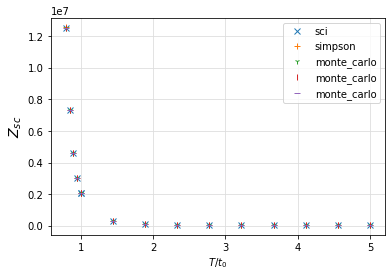

In [12]:
start = 15
major_ticks = np.arange(0, 5, 20)
minor_ticks = np.arange(0, 5, 5)
markers = ["x","+","1","|","_"]

for i in range(len(Z_hyb)):
    plt.plot(T_values[start:],[x for (x,y) in Z_hyb[i][0][start:]],markers[i], label = Z_hyb[i][1])

plt.xlabel(xlabel='$T/t_0$')
plt.ylabel(ylabel=r'$Z_{sc}$', fontsize = 14.)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)

plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.legend()
#plt.savefig("Z.pdf")

30

In [5]:
t_0 = 1
w_0 = 1
gamma = 1
beta =1

In [6]:

M = 50

H = H_space(L=2,M=M,n_e=1, show = False, is_periodic = True)
H.Hamiltonian(t_0,w_0,gamma)
H.H_diag()

E_qm = H.Expected_value(H.H_matrix,beta,is_Mat=True,is_T=False)

H.Hamiltonian(0,w_0,0)
Hph_qm = H.Expected_value(H.H_matrix,beta,is_Mat=True,is_T=False)

H.Hamiltonian(0,0,gamma)
Hphe_qm = H.Expected_value(H.H_matrix,beta,is_Mat=True,is_T=False)

H.Hamiltonian(t_0,0,0)
He_qm = H.Expected_value(H.H_matrix,beta,is_Mat=True,is_T=False)


                        


In [7]:
t = hybrid()
t.H_e(beta,t_0,w_0,gamma) 
Hph = t.H_ph(beta,t_0,w_0,gamma) 
H_phe = t.H_phe(beta,t_0,w_0,gamma)
H_e = t.H_e(beta,t_0,w_0,gamma)
E = t.E(beta,t_0,w_0,gamma)

In [14]:
T_values = np.concatenate((np.linspace(0.03,1,20),np.linspace(1,5,10)))
beta_values = 1/(T_values)

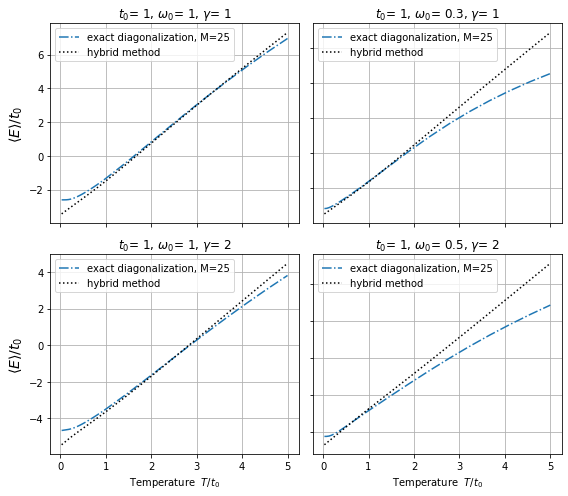

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(8,7))
j=0
for (x,y) in axs:
    title = r'$t_0$='+' '+ str(params[j][0])+', '\
    +r'$\omega_0$='+' '+ str(params[j][1])+', '+r'$\gamma$='+' '+ str(params[j][2])
    
    x.plot(T_values, E_qm[j], color='tab:blue', label = 'exact diagonalization, M=25',linestyle='dashdot')
    x.set_ylabel(ylabel=r'$\langle E \rangle/t_0$', fontsize = 14.)
    x.plot(T_values, [a for (a,b) in E_hyb[j]], color ='black', label = 'hybrid method',linestyle='dotted')
    x.set_title(title)
    x.set_xlabel(xlabel="Temperature"+'  '+ r'$T/t_0$')
    j+=1
    title = r'$t_0$='+' '+ str(params[j][0])+', '\
    +r'$\omega_0$='+' '+ str(params[j][1])+', '+r'$\gamma$='+' '+ str(params[j][2])
    
    y.plot(T_values, E_qm[j], color='tab:blue', label = 'exact diagonalization, M=25',linestyle='dashdot')
    y.set_ylabel(ylabel=r'$\langle E \rangle/t_0$', fontsize = 14.)
    y.plot(T_values, [a for (a,b) in E_hyb[j]], color ='black', label = 'hybrid method',linestyle='dotted')
    y.set_title(title)
    y.set_xlabel(xlabel="Temperature"+'  '+ r'$T/t_0$')
    j+=1
for ax in fig.get_axes():
    ax.label_outer()
    ax.grid()
    ax.legend()

fig.tight_layout()   
#fig.savefig("E.pdf")

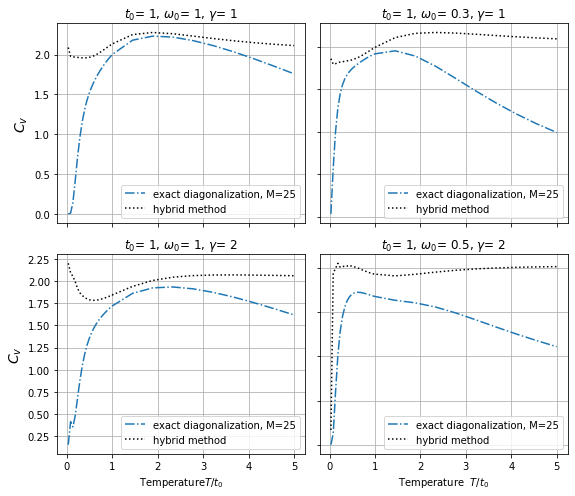

In [14]:
qm = C_v_qm
hyb = C_v_hyb
yaxsis =r'$C_v$'
fig, axs = plt.subplots(2, 2, figsize=(8,7))
j=0
for (x,y) in axs:
    title = r'$t_0$='+' '+ str(params[j][0])+', '\
    +r'$\omega_0$='+' '+ str(params[j][1])+', '+r'$\gamma$='+' '+ str(params[j][2])
    
    x.plot(T_values, qm[j], color='tab:blue', label = 'exact diagonalization, M=25',linestyle='dashdot')
    x.set_ylabel(ylabel=yaxsis, fontsize = 14.)
    x.plot(T_values, [a for a in hyb[j]], color ='black', label = 'hybrid method',linestyle='dotted')
    x.set_title(title)
    x.set_xlabel(xlabel="Temperature"+ r'$T/t_0$')
    j+=1
    title = r'$t_0$='+' '+ str(params[j][0])+', '\
    +r'$\omega_0$='+' '+ str(params[j][1])+', '+r'$\gamma$='+' '+ str(params[j][2])
    
    y.plot(T_values, qm[j], color='tab:blue', label = 'exact diagonalization, M=25',linestyle='dashdot')
    y.set_ylabel(ylabel=yaxsis, fontsize = 14.)
    y.plot(T_values, [a for a in hyb[j]], color ='black', label = 'hybrid method',linestyle='dotted')
    y.set_title(title)
    y.set_xlabel(xlabel="Temperature"+'  '+ r'$T/t_0$')
    j+=1
for ax in fig.get_axes():
    ax.label_outer()
    ax.grid()
    ax.legend()

fig.tight_layout()   
#fig.savefig("cv.pdf")

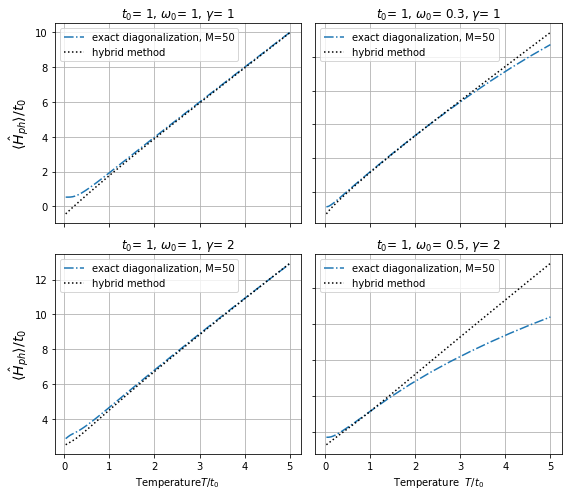

In [15]:
qm = Hph_qm
hyb = Hph_hyb

yaxsis =r'$\langle\hat{H}_{ph}\rangle/t_0$'
fig, axs = plt.subplots(2, 2, figsize=(8,7))
j=0
for (x,y) in axs:
    title = r'$t_0$='+' '+ str(params[j][0])+', '\
    +r'$\omega_0$='+' '+ str(params[j][1])+', '+r'$\gamma$='+' '+ str(params[j][2])
    
    x.plot(T_values, qm[j], color='tab:blue', label = 'exact diagonalization, M=50',linestyle='dashdot')
    x.set_ylabel(ylabel=yaxsis, fontsize = 14.)
    x.plot(T_values, [a for a in hyb[j]], color ='black', label = 'hybrid method',linestyle='dotted')
    x.set_title(title)
    x.set_xlabel(xlabel="Temperature"+ r'$T/t_0$')
    j+=1
    title = r'$t_0$='+' '+ str(params[j][0])+', '\
    +r'$\omega_0$='+' '+ str(params[j][1])+', '+r'$\gamma$='+' '+ str(params[j][2])
    
    y.plot(T_values, qm[j], color='tab:blue', label = 'exact diagonalization, M=50',linestyle='dashdot')
    y.set_ylabel(ylabel=yaxsis, fontsize = 14.)
    y.plot(T_values, [a for a in hyb[j]], color ='black', label = 'hybrid method',linestyle='dotted')
    y.set_title(title)
    y.set_xlabel(xlabel="Temperature"+'  '+ r'$T/t_0$')
    j+=1
for ax in fig.get_axes():
    ax.label_outer()
    ax.grid()
    ax.legend()

fig.tight_layout()
#fig.savefig("Hph.pdf")

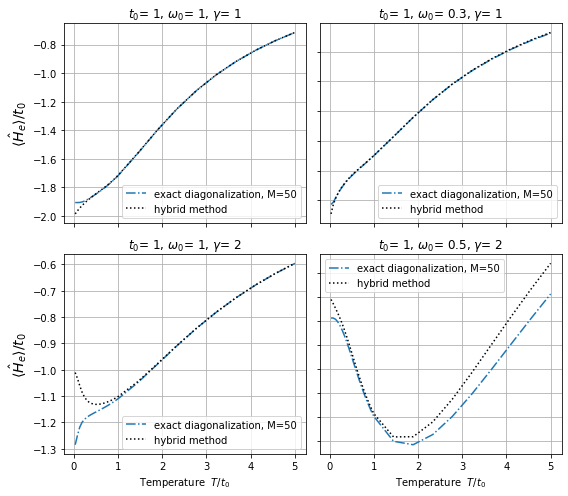

In [16]:
qm = He_qm
hyb = He_hyb


yaxsis =r'$\langle\hat{H}_{e}\rangle/t_0$'
fig, axs = plt.subplots(2, 2, figsize=(8,7))
j=0
for (x,y) in axs:
    title = r'$t_0$='+' '+ str(params[j][0])+', '\
    +r'$\omega_0$='+' '+ str(params[j][1])+', '+r'$\gamma$='+' '+ str(params[j][2])
    
    x.plot(T_values, qm[j], color='tab:blue', label = 'exact diagonalization, M=50',linestyle='dashdot')
    x.set_ylabel(ylabel=yaxsis, fontsize = 14.)
    x.plot(T_values, [a for a in hyb[j]], color ='black', label = 'hybrid method',linestyle='dotted')
    x.set_title(title)
    x.set_xlabel(xlabel="Temperature"+'  '+ r'$T/t_0$')
    j+=1
    title = r'$t_0$='+' '+ str(params[j][0])+', '\
    +r'$\omega_0$='+' '+ str(params[j][1])+', '+r'$\gamma$='+' '+ str(params[j][2])
    
    y.plot(T_values, qm[j], color='tab:blue', label = 'exact diagonalization, M=50',linestyle='dashdot')
    y.set_ylabel(ylabel=yaxsis, fontsize = 14.)
    y.plot(T_values, [a for a in hyb[j]], color ='black', label = 'hybrid method',linestyle='dotted')
    y.set_title(title)
    y.set_xlabel(xlabel="Temperature"+'  '+ r'$T/t_0$')
    j+=1
for ax in fig.get_axes():
    ax.label_outer()
    ax.grid()
    ax.legend()

fig.tight_layout()
#fig.savefig("He.pdf")

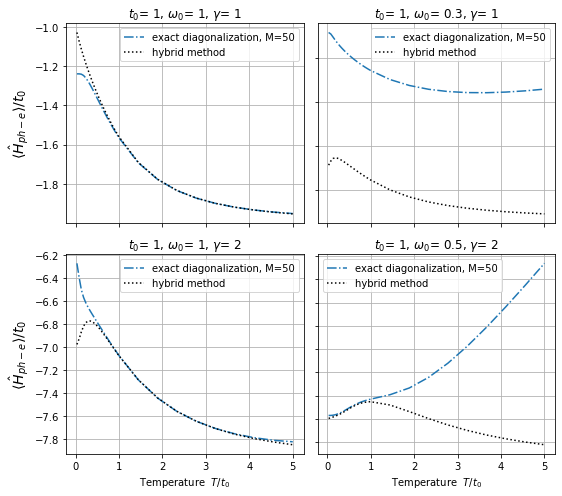

In [26]:
qm = Hphe_qm
hyb = Hphe_hyb  
yaxsis =r'$\langle\hat{H}_{ph-e}\rangle/t_0$'
fig, axs = plt.subplots(2, 2, figsize=(8,7))
j=0
for (x,y) in axs:
    title = r'$t_0$='+' '+ str(params[j][0])+', '\
    +r'$\omega_0$='+' '+ str(params[j][1])+', '+r'$\gamma$='+' '+ str(params[j][2])
    
    x.plot(T_values, qm[j], color='tab:blue', label = 'exact diagonalization, M=50',linestyle='dashdot')
    x.set_ylabel(ylabel=yaxsis, fontsize = 14.)
    x.plot(T_values, [a for a in hyb[j]], color ='black', label = 'hybrid method',linestyle='dotted')
    x.set_title(title)
    x.set_xlabel(xlabel="Temperature"+'  '+ r'$T/t_0$')
    j+=1
    title = r'$t_0$='+' '+ str(params[j][0])+', '\
    +r'$\omega_0$='+' '+ str(params[j][1])+', '+r'$\gamma$='+' '+ str(params[j][2])
    
    y.plot(T_values, qm[j], color='tab:blue', label = 'exact diagonalization, M=50',linestyle='dashdot')
    y.set_ylabel(ylabel=yaxsis, fontsize = 14.)
    y.plot(T_values, [a for a in hyb[j]], color ='black', label = 'hybrid method',linestyle='dotted')
    y.set_title(title)
    y.set_xlabel(xlabel="Temperature"+'  '+ r'$T/t_0$')
    j+=1
for ax in fig.get_axes():
    ax.label_outer()
    ax.grid()
    ax.legend()

fig.tight_layout()
#fig.savefig("Hphe.pdf")

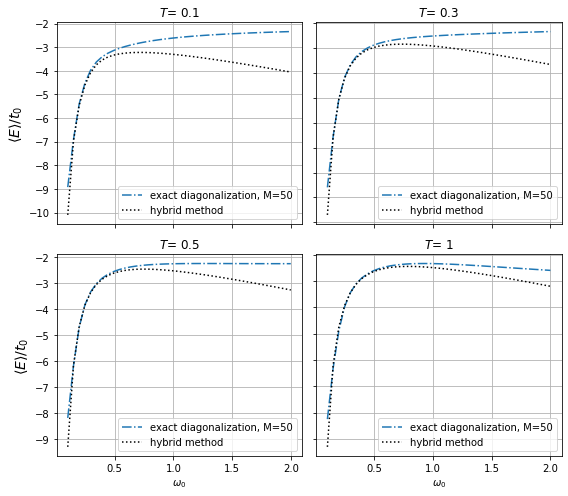

In [32]:
qm = Delta_qm
hyb = Delta_hyb 
x_ax = omega
yaxsis =r'$\langle E \rangle/t_0$'
fig, axs = plt.subplots(2, 2, figsize=(8,7))
j=0
for (x,y) in axs:
    title = r'$T$='+' '+ str(T[j])
    
    x.plot(x_ax, qm[j], color='tab:blue', label = 'exact diagonalization, M=50',linestyle='dashdot')
    x.set_ylabel(ylabel=yaxsis, fontsize = 14.)
    x.plot(x_ax, [a for (a,b) in hyb[j]], color ='black', label = 'hybrid method',linestyle='dotted')
    x.set_title(title)
    x.set_xlabel(xlabel='$\omega_0$')
    j+=1
    title = r'$T$='+' '+ str(T[j])
    
    y.plot(x_ax, qm[j], color='tab:blue', label = 'exact diagonalization, M=50',linestyle='dashdot')
    y.set_ylabel(ylabel=yaxsis, fontsize = 14.)
    y.plot(x_ax, [a for (a,b) in hyb[j]], color ='black', label = 'hybrid method',linestyle='dotted')
    y.set_title(title)
    y.set_xlabel(xlabel='$\omega_0$')
    j+=1
for ax in fig.get_axes():
    ax.label_outer()
    ax.grid()
    ax.legend()

fig.tight_layout()
plt.savefig("Eomega.pdf")

-2.0